<h1>XGBoost</h1>

En este cuaderno, se utiliza XGBoost para realizar la imputación supervisada de valores faltantes. XGBoost es un potente algoritmo de boosting basado en árboles de decisión, conocido por su eficiencia y precisión en tareas de clasificación y regresión. Su capacidad para manejar valores faltantes de forma nativa lo convierte en una herramienta adecuada para la imputación de datos.

En este caso, se utiliza un conjunto de datos reducido debido a la alta capacidad computacional que requieren los modelos basados en árboles, como Random Forest y, en particular, los modelos de boosting como XGBoost. El uso de este conjunto de datos permite evaluar de manera más eficiente los resultados de imputación en condiciones de recursos computacionales limitados.

El objetivo de este cuaderno es:

- Entrenar un modelo de XGBoost para imputar valores faltantes en un conjunto de datos.
- Evaluar el rendimiento del modelo bajo distintos niveles de incompletitud en los datos.
- Obtener resultados para comparar los resultados de la imputación con otros enfoques, como autoencoders con atención y K-Nearest Neighbors (KNN)

Descripción del enfoque
- Entrenamiento supervisado: Se entrena el modelo de XGBoost con los datos completos, utilizando las características disponibles para predecir los valores faltantes.
- Imputación: El modelo predice los valores faltantes de las columnas incompletas.
- Evaluación: Se analiza el impacto de la imputación en función de los diferentes niveles de datos faltantes.
- Almacenamiento: Los datasets imputados se guardan para uso futuro.

## Importación de librerias



In [18]:

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


# Dataset

## Loading data

Se utilizan los subconjuntos de datos generados en preprocesamiento, en formato parquet para optimizar la lectura

In [19]:
df_train = pd.read_parquet('../data/processed/df_train_reduced.parquet')
df_test= pd.read_parquet('../data/processed/df_test_reduced.parquet')
df_test_missing_10 = pd.read_parquet('../data/processed/df_test_reduced_missing_10.parquet')
df_test_missing_20 = pd.read_parquet('../data/processed/df_test_reduced_missing_20.parquet')
df_test_missing_30 = pd.read_parquet('../data/processed/df_test_reduced_missing_30.parquet')
df_test_missing_40 = pd.read_parquet('../data/processed/df_test_reduced_missing_40.parquet')

In [20]:
df_test_missing_10.head(10)

,10335183_chrXV_303214_G_T,10341838_chrXV_309869_T_C,10341923_chrXV_309954_G_A,10342190_chrXV_310221_T_C,10342543_chrXV_310574_A_G,10344120_chrXV_312151_C_T,10346156_chrXV_314187_C_G,10349298_chrXV_317329_C_T,3141305_chrV_249350_C_T,10383039_chrXV_351070_C_T,...,10640336_chrXV_608367_C_T,1428699_chrIV_68677_T_C,1428933_chrIV_68911_A_C,6970183_chrXI_391971_C_T,6970060_chrXI_391848_C_T,6969970_chrXI_391758_T_A,3698349_chrVI_229520_A_G,6969924_chrXI_391712_C_T,5535875_chrIX_143302_C_T,7948843_chrXII_703815_C_T
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,2.0,1.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,2.0,2.0,2.0,NaN,2.0,NaN,2.0,2.0,2.0
4,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,...,1.0,1.0,1.0,2.0,2.0,NaN,2.0,2.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,2.0,NaN,2.0,1.0,2.0,2.0,2.0
6,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,...,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0
7,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0
9,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,NaN,2.0,2.0,1.0


In [21]:
df_train.head(10)

,10335183_chrXV_303214_G_T,10341838_chrXV_309869_T_C,10341923_chrXV_309954_G_A,10342190_chrXV_310221_T_C,10342543_chrXV_310574_A_G,10344120_chrXV_312151_C_T,10346156_chrXV_314187_C_G,10349298_chrXV_317329_C_T,3141305_chrV_249350_C_T,10383039_chrXV_351070_C_T,...,10640336_chrXV_608367_C_T,1428699_chrIV_68677_T_C,1428933_chrIV_68911_A_C,6970183_chrXI_391971_C_T,6970060_chrXI_391848_C_T,6969970_chrXI_391758_T_A,3698349_chrVI_229520_A_G,6969924_chrXI_391712_C_T,5535875_chrIX_143302_C_T,7948843_chrXII_703815_C_T
0,1,1,1,1,1,1,1,1,2,2,...,2,2,2,1,1,1,2,1,1,1
1,2,2,2,2,2,2,2,2,1,1,...,1,2,2,1,1,1,1,1,1,2
2,2,2,2,2,2,2,2,1,2,1,...,1,1,1,2,2,2,1,2,2,1
3,1,1,1,1,1,1,1,1,1,2,...,2,1,1,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,1,2,...,1,2,2,1,1,1,2,1,2,1
5,2,2,2,2,2,2,2,2,2,2,...,2,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,1,2,1,2
7,2,2,2,2,2,2,2,2,1,1,...,1,2,2,2,2,2,2,2,1,1
8,1,1,1,1,1,1,1,1,2,1,...,1,1,1,1,1,1,1,1,2,1
9,1,1,1,1,1,1,1,1,2,2,...,2,2,2,1,1,1,2,1,1,2


### Mostramos el numero de clases de entrenamieno y verificamos que están balanceadas

In [22]:
# Contar los valores de 0 y 1 en todo el DataFrame
total_counts = df_train.apply(pd.Series.value_counts).sum(axis=1)
print("Conteo total de clases en todo el DataFrame:")
print(total_counts)

Conteo total de clases en todo el DataFrame:
1    1756511
2    1756489
dtype: int64


## Modelo: XGBoost

Se define la función que se encarga de entrenar el modelo

In [23]:
from xgboost import XGBClassifier  

def train_model(df_train):
    X_train = df_train
    y_train = X_train.values-1  # las clases son [1, 2], ahora serán [0, 1]

    # Entrenar un XGBClassifier
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)  # Entrenamos el modelo usando los valores no faltantes
    return xgb_model


### Test 

In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

def predict_missing_values_for_row(row, model, known_features, missing_features):
    # Asegurarse de que la fila tenga los nombres de las columnas correctos
    X_known = row[known_features].values.reshape(1, -1)

    # Crear un dataframe vacío con las columnas del modelo y rellenar con ceros (o cualquier valor temporal)
    X_full = pd.DataFrame(np.zeros((1, model.n_features_in_)), columns=model.feature_names_in_)
    
    # Rellenar las características conocidas en sus correspondientes columnas
    X_full.loc[:, known_features] = X_known

    # Hacer la predicción usando el modelo entrenado y volver a las clases originales [1, 2]
    pred = model.predict(X_full)[0] + 1  # Sumar 1 para regresar a [1, 2]

    return pred, missing_features

# Imputar valores faltantes y calcular métricas
def impute_and_evaluate(df_test_missing, df_test_original, model):
    df_test_imputed = df_test_missing.copy()  # Mantener el dataframe con su estructura

    all_y_true = []
    all_y_pred = []

    # Iterar sobre cada fila del dataset
    for index, row in df_test_missing.iterrows():
        if row.isna().any():  # Solo imputar filas con valores faltantes
            known_features = row.dropna().index  # Características conocidas (no NaN)
            missing_features = row.index[row.isna()]  # Características con NaN

            # Si hay suficientes características conocidas, predecir los NaN
            if len(known_features) > 0:
                pred, missing_features = predict_missing_values_for_row(
                    row, model, known_features, missing_features
                )

                # Imputar los valores predichos en el dataset
                df_test_imputed.loc[index, missing_features] = pred[:len(missing_features)]

                # Guardar los valores verdaderos y predichos para evaluación
                y_true = df_test_original.loc[index, missing_features]
                all_y_true.extend(y_true)
                all_y_pred.extend(pred[:len(missing_features)])  # No sumamos aquí

    # Calcular las métricas de evaluación
    accuracy_general = accuracy_score(all_y_true, all_y_pred)
    f1_macro = f1_score(all_y_true, all_y_pred, average='macro')
    precision_macro = precision_score(all_y_true, all_y_pred, average='macro')
    recall_macro = recall_score(all_y_true, all_y_pred, average='macro')

    return df_test_imputed, accuracy_general, f1_macro, precision_macro, recall_macro

# Función para procesar diferentes niveles de missingness
def process_multiple_missingness_levels(df_train, df_test, missingness_levels, model):
    results = {
        "accuracy": [],
        "f1": [],
        "precision": [],
        "recall": []
    }

    for level in missingness_levels:
        df_test_missing = globals()[f'df_test_missing_{level}']  # Conjunto de test con missingness
        
        # Imputar los valores faltantes
        df_test_imputed, accuracy, f1, precision, recall = impute_and_evaluate(
            df_test_missing, df_test, model
        )

        # Guardar las métricas
        results["accuracy"].append(accuracy)
        results["f1"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        
        # Guardar el conjunto imputado como una variable global
        globals()[f'df_test_missing_{level}_imputed'] = df_test_imputed

    return results

# Función para graficar los resultados
def plot_multiple_metrics(missingness_levels, metrics_dict):
    plt.figure(figsize=(10, 6))
    
    for metric_name, metric_values in metrics_dict.items():
        plt.plot(missingness_levels, metric_values, marker='o', label=f'{metric_name}')
    
    plt.xlabel('Porcentaje de valores faltantes')
    plt.ylabel('Métrica')
    plt.title('Comparación de métricas vs Porcentaje de valores faltantes')
    plt.grid(True)
    plt.legend()
    plt.show()


def detailed_metrics_report(missingness_levels, metrics_dict):
    # Reportar métricas numéricas
    print("==== Reporte Detallado de Métricas ====\n")
    for metric_name, metric_values in metrics_dict.items():
        print(f"Métricas para {metric_name}:")
        for i, level in enumerate(missingness_levels):
            print(f"- Porcentaje de valores faltantes {level}%: {metric_values[i]:.4f}")
        print("\n")
    


In [25]:
xgb_model = train_model(df_train) 


In [26]:
# Llamar al proceso con el modelo ya entrenado
missingness_levels = [10, 20, 30, 40]
metrics_results = process_multiple_missingness_levels(df_train, df_test, missingness_levels, xgb_model)

In [27]:
detailed_metrics_report(missingness_levels, metrics_results)

==== Reporte Detallado de Métricas ====

Métricas para accuracy:
- Porcentaje de valores faltantes 10%: 0.5275
- Porcentaje de valores faltantes 20%: 0.5260
- Porcentaje de valores faltantes 30%: 0.5197
- Porcentaje de valores faltantes 40%: 0.5141


Métricas para f1:
- Porcentaje de valores faltantes 10%: 0.5264
- Porcentaje de valores faltantes 20%: 0.5215
- Porcentaje de valores faltantes 30%: 0.5087
- Porcentaje de valores faltantes 40%: 0.4943


Métricas para precision:
- Porcentaje de valores faltantes 10%: 0.5281
- Porcentaje de valores faltantes 20%: 0.5275
- Porcentaje de valores faltantes 30%: 0.5220
- Porcentaje de valores faltantes 40%: 0.5182


Métricas para recall:
- Porcentaje de valores faltantes 10%: 0.5278
- Porcentaje de valores faltantes 20%: 0.5264
- Porcentaje de valores faltantes 30%: 0.5200
- Porcentaje de valores faltantes 40%: 0.5152




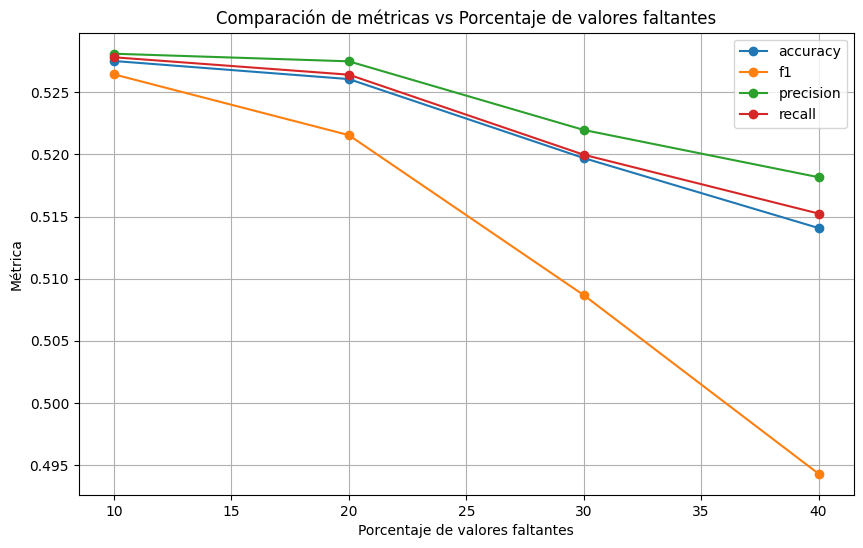

In [28]:
# Graficar resultados
plot_multiple_metrics(missingness_levels, metrics_results)

### Guardar datasets imputados a partir de los distintos datasets con diferentes porcentajes de missingness y modelo generado

In [29]:
import os
import h5py
import pickle
import numpy as np

def save_model(rf_model, model_path):
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Crear directorios si no existen
    
    # Serializamos el modelo con pickle en un buffer de bytes
    model_bytes = pickle.dumps(rf_model)
    
    # Convertir el buffer a un array NumPy para que HDF5 lo maneje correctamente
    model_array = np.frombuffer(model_bytes, dtype='uint8')
    
    # Guardar el modelo en un archivo HDF5 con compresión GZIP
    with h5py.File(model_path, 'w') as f:
        # Dividimos el array en chunks y aplicamos compresión
        f.create_dataset('random_forest_model', data=model_array, compression="gzip", compression_opts=9)
    
    print(f"Modelo guardado y comprimido en {model_path}")


# Función para guardar los datasets imputados
def save_imputed_datasets(df_imputed, level, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Crear directorios si no existen
    file_path = os.path.join(output_dir, f'df_test_missing_{level}_imputed.parquet')
    df_imputed.to_csv(file_path, index=False)
    print(f"Dataset imputado guardado en {file_path}")


In [30]:


# Guardar el modelo
model_output_path = "../models/XGBoost/XGBoost_model.h5"
save_model(xgb_model, model_output_path)

# Guardar los datasets imputados
for level in missingness_levels:
    df_test_imputed = globals()[f'df_test_missing_{level}_imputed']
    data_output_dir = "../data/generated/xgboost"
    save_imputed_datasets(df_test_imputed, level, data_output_dir)


Modelo guardado y comprimido en ../models/XGBoost/XGBoost_model.h5
Dataset imputado guardado en ../data/generated/xgboost/df_test_missing_10_imputed.parquet
Dataset imputado guardado en ../data/generated/xgboost/df_test_missing_20_imputed.parquet
Dataset imputado guardado en ../data/generated/xgboost/df_test_missing_30_imputed.parquet
Dataset imputado guardado en ../data/generated/xgboost/df_test_missing_40_imputed.parquet


Así se cargaría el modelo de ser necesario desde HDF5:
with h5py.File(model_output_path, 'r') as f:
    model_bytes = f['xgboost_model'][()]
    f_model_loaded = joblib.loads(model_bytes)
    